In [1]:
import torch
import argparse
import math
import torch.nn as nn 
from torch.nn.functional import leaky_relu, softmax
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

from GANutils import *
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [3]:
data = pd.read_pickle('Data/TU_onehot')

In [4]:
cat = Counter([v.split('_')[0] for v in list(data.columns)])
cat_total = sum(cat.values())
cat_n = list(cat.values())
INPUT_SIZE = 500

In [80]:
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]), requires_grad=False)
    return n



def softmax2onehot(x):
    x=x.to(device)
    max_idx = torch.argmax(x, 1, keepdim=True).to(device)
    one_hot = torch.FloatTensor(x.shape).to(device)
    one_hot.zero_().to(device)
    return one_hot.scatter_(1, max_idx, 1).to(device)

## Generator

In [182]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.1),
            #nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.1),
            #nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.out = nn.Sequential( 
            nn.Linear(hidden_size * 2, self.output_size))
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.out(x)
        ### Softmax per class
        x = (x.split(self.cat_n, dim=1))
        out = torch.cat([softmax(v, dim =1) for v in x], dim=1)
        return out


In [176]:
G=Generator(input_size=INPUT_SIZE, hidden_size = 4, cat=cat)
G.to(device)
optimal = torch.optim.RMSprop(G.parameters(),
                                                  lr = 0.1,
                                                  centered=False)
loss = nn.BCELoss()
z = gen_noise(INPUT_SIZE, 64).to(device)

In [181]:
for _ in range(5):
    x_fake = G.forward(z)
    o_loss = loss(torch.mean(x_fake, dim=0), torch.ones(400, 1).to(device) )
    a = list(G.parameters())[1]
    x_fake = x_fake.split(cat_n, dim=1)
    x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
    x_fake = x_fake.to(device)

    o_loss.backward()
    optimal.step()
    G.zero_grad()
    b = list(G.parameters())[1]
    print(o_loss, torch.sum(a-b))


tensor(34.9222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(28.0225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(27.3937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(24.2529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(20.7490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0., device='cuda:0', grad_fn=<SumBackward0>)


## Discriminator


In [46]:
class Discriminator(nn.Module):
    def __init__(self, input_size:int, output_size=1, vanila=False):
        '''
        input_size: size of the data
        output_size: is always 1 
        vanila: if True, Sigmoid is going to applied on the last layer
        '''
        super(Discriminator,self).__init__()
        
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        if vanila:
            self.out = nn.Sequential(
                torch.nn.Linear(256, output_size),
                torch.nn.Sigmoid()
                )
        else:
            self.out = nn.Sequential(
                torch.nn.Linear(256, output_size))
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.out(x)
        return x
    
    def clip(self, thr):
        for p in self.parameters():
            p.data.clamp_(-thr, thr)



In [63]:
D = Discriminator(500).to(device)
optimal = torch.optim.RMSprop(D.parameters(),
                                                  lr = 0.01,
                                                  centered=True)
z = Variable(gen_noise(INPUT_SIZE, 2).to(device))
out = D.forward(z)
loss = torch.mean(out)
loss.backward()
print(loss, z.grad)
optimal.step()

tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward0>) None


In [223]:
class GAN():
    def __init__(self, 
                 data, 
                 cat, 
                 epochs = 2500,
                 batch_size=64,           
                 gen_learn_rate=1E-5,   
                 disc_learn_rate=1E-8,
                 vanila=False): 
        #Data
        self.cat = cat
        self.cat_n = list(cat.values())
        self.onehot_size = sum(self.cat.values())
        self.train_val_split(data, batch_size)
        
        #Networks
        self.G = Generator(input_size=INPUT_SIZE, hidden_size=1024, cat=self.cat).to(device)
        self.D = Discriminator(input_size=self.onehot_size, vanila=vanila).to(device)
        self.D.clip(0.01)
        
        #Parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.gen_learn_rate = gen_learn_rate
        self.disc_learn_rate = disc_learn_rate

        ''''
        ADAM optimizer does not give good results 
        
        self.generator_optim = torch.optim.Adam(self.G.parameters(),
                                                gen_learn_rate, 
                                                eps = 10E-8, 
                                                betas=(0.5, 0.999)) #0.6
        self.discriminator_optim = torch.optim.Adam(self.D.parameters(), disc_learn_rate, betas=(0.4, 0.999))
        '''
        self.generator_optim = torch.optim.RMSprop(self.G.parameters(),
                                                  lr = self.gen_learn_rate,
                                                  centered=True)
        self.discriminator_optim = torch.optim.RMSprop(self.D.parameters(),
                                                      lr = self.disc_learn_rate,
                                                      centered=True)
        
    def train_val_split(self, data, batch_size):
        train, val = train_test_split(data, test_size=0.2)
        self.train = DataLoader(torch.tensor(train.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=4)
        self.val  = DataLoader(torch.tensor(val.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=4)
    def sample(self, n_samples: int):
        '''
        Generate the data data with Generator network
        n_samples: usually equals to the batch size
        '''
        z = gen_noise(INPUT_SIZE, n_samples)
        z = Variable(z, requires_grad=False).to(device)
        return self.G.forward(z)
    
    def discriminator_train_step(self, x):
        '''
        x: set of real data 
        '''
        batch_size = x.shape[0]
        x_fake = self.sample(batch_size)
    
    def reset_gradient(self):
        self.D.zero_grad()
        self.G.zero_grad()
        
        
    def fit(self, n_critic=1, n_gen=3):
        self.discriminator_loss, self.generator_loss = [], []
        for epoch in range(self.epochs):
            batch_d_loss, batch_g_loss = [], []
            for x in self.val:
                ## Reset gradient for both networks (on new epoch)
                self.reset_gradient()
                ## Determine the batch size
                batch_size = x.shape[0]
                # True data is given label 1, while fake data is given label 0
                #true_label = torch.ones(batch_size, 1).to(device)
                #fake_label = torch.zeros(batch_size, 1).to(device)
                #Step 1. TRAIN THE GENERATOR FOR THE FIRST TIME
                if (n_gen-1)>0:
                    for _ in range(n_gen-1):
                        x_fake = self.sample(batch_size).to(device)
                        x_fake = x_fake.split(self.cat_n, dim=1)
                        x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
                        x_fake = x_fake.to(device)
                
                        output = self.D.forward(x_fake)
        
                        G_loss = -torch.mean(output)
                        G_loss.backward()
                        self.generator_optim.step()
                        self.reset_gradient()
                        batch_g_loss.append(G_loss.item())
                

                for _ in range(n_critic):
                    # Step 1. Send real data through discriminator
                    #         and backpropagate its errors.
                    x_true = Variable(x).float().to(device)
                    output_true = self.D.forward(x_true)
        

                    # Step 2. Generate fake data G(z), where z ~ N(0, 1)
                    #         is a latent code.
                    x_fake = self.sample(batch_size)
                    x_fake = x_fake.split(self.cat_n, dim=1)
                    x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
                    x_fake = x_fake.to(device)
                    # Step 3. Send fake data through discriminator
                    #         propagate error and update D weights.
                    # --------------------------------------------
                    # Note: detach() is used to avoid compounding generator gradients
                    output_fake = self.D.forward(x_fake.detach()) 
        
                    D_loss = -(torch.mean(output_true) - torch.mean(output_fake))
                    D_loss.backward()
                    self.discriminator_optim.step()
                    
                    # Weight clipping
                    self.D.clip(0.01)
                    self.reset_gradient()
                    batch_d_loss.append(D_loss.item())
                
                # Step 4. Send fake data through discriminator _again_
                #         propagate the error of the generator and
                #         update G weights.
                x_fake = self.sample(batch_size)
                x_fake = x_fake.split(self.cat_n, dim=1)
                x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
                x_fake = x_fake.to(device)
                
                output = self.D.forward(x_fake)
        
                G_loss = -torch.mean(output)
                G_loss.backward()
                self.generator_optim.step()
        
                
                batch_g_loss.append(G_loss.item())
            
            self.discriminator_loss.append(np.mean(batch_d_loss))
            self.generator_loss.append(np.mean(batch_g_loss))
            
            
            clear_output()
            print("Epoch: %3d || D Loss: %5.5f (rc:%3.3f fc:%3.3f) || G Loss: %5.5f " %(epoch, np.mean(batch_d_loss), 
                                                                                        torch.mean(output_true),
                                                                                        torch.mean(output_fake),
                                                                                    np.mean(batch_g_loss)))

            # -- Plotting --
            f, axarr = plt.subplots(1, 2, figsize=(18, 7))

            # Loss
            axarr[0].set_xlabel('Epoch')
            axarr[0].set_ylabel('Loss')
            axarr[0].set_title('Discriminator Loss || lr= %s' %self.disc_learn_rate )
            axarr[1].set_xlabel('Epoch')
            axarr[1].set_ylabel('Loss')
            axarr[1].set_title('Generator Loss  || lr= %s' %self.gen_learn_rate )

            axarr[0].plot(np.arange(epoch+1), self.discriminator_loss)
            axarr[1].plot(np.arange(epoch+1), self.generator_loss, linestyle="--")
            plt.show()
    def print_out(self):
        pass
    def synthesise(self, num=2):
        data_dummy = pd.DataFrame(columns=data.columns, dtype=np.int32)
        x_fake = self.sample(num)
        x_fake = x_fake.split(self.cat_n, dim=1)
        x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
        x_fake = np.array(x_fake.cpu())[0].astype(int)
        data_dummy.loc[-1] =np.array(x_fake)[0].astype(int)
        return back_from_dummies(data_dummy)
            

In [224]:
gan = GAN(data = data, cat = cat)

In [225]:
#gan.show_gen(2)

Epoch:  43 || D Loss: -0.00130 (rc:-0.007 fc:-0.009) || G Loss: 0.00878 


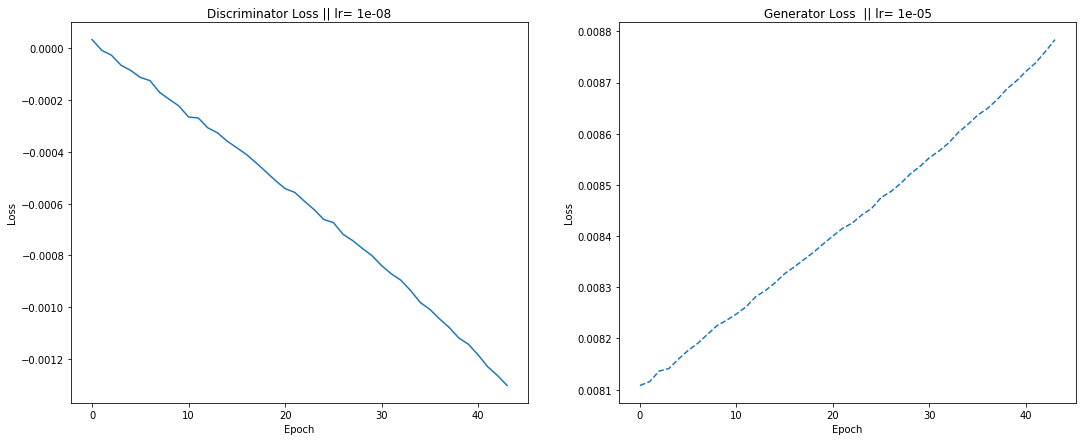

In [ ]:
gan.fit(n_critic=1, n_gen=3) ##add num of critics